### Generate M random potentials on [0, L] as sum of n gaussian kernels on G discretization points


there are 3 uniformly distributed random parameters a, b, c
the potential is calculated by:

$$
V(x) = -\sum_{n=1}^{3} a_n \exp \left(-\frac{(x - b_n)^2}{2c_n^2} \right)
$$

### Then solve the schroedinger equation in atomic units for 4 spinless non-interacting fermions.

The shooting numerov algorithm calculates a forward pass and a backward pass solution.

The final solution is then found by aligning the two passes and finding a good split point to concatenate them.

All integrals are approximated by the trapezoidal method.
The numerical differentiation for the laplacian uses the standard approximation.

### Usage:

Setting the dataset variable to different values will allow generating all the variations of the datasets:
standard, recreate, recreate/fine_0.125, ..., recreate/fine_10


# Initialization and shared files

## Initialization

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
%matplotlib inline

try:
    from google.colab import drive
    drive.mount('/content/gdrive')
    os.chdir("/content/gdrive/My Drive/Projects/QuantumFlow/notebooks")
except:
    pass

if tf.test.gpu_device_name() == '/device:GPU:0':
    print('Found GPU')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Found GPU


## generate_potentials.py

In [2]:
%%writefile ../quantumflow/generate_potentials.py
import tensorflow as tf
import numpy as np

def tf_generate_potentials(dataset_size=2000, points=500, n_gauss=3, length=1.0,
                           a_minmax=(0.0, 3*10.0), b_minmax=(0.4, 0.6), c_minmax=(0.03, 0.1), return_x=False):
    x = tf.linspace(0.0, length, points, name="x")

    a = tf.random_uniform((dataset_size, 1, n_gauss), minval=a_minmax[0], maxval=a_minmax[1], name="a")
    b = tf.random_uniform((dataset_size, 1, n_gauss), minval=b_minmax[0]*length, maxval=b_minmax[1]*length, name="b")
    c = tf.random_uniform((dataset_size, 1, n_gauss), minval=c_minmax[0]*length, maxval=c_minmax[1]*length, name="c")

    curves = -tf.square(tf.expand_dims(tf.expand_dims(x, 0), 2) - b)/(2*tf.square(c))
    curves = -a*tf.exp(curves)

    potentials = tf.reduce_sum(curves, -1, name="potentials")

    if return_x:
        return potentials, x
    else:
        return potentials

def generate_potentials(dataset_size=2000, points=500, n_gauss=3, length=1.0,
                        a_minmax=(0.0, 3*10.0), b_minmax=(0.4, 0.6), c_minmax=(0.03, 0.1), return_x=False, seed=0):
    g = tf.Graph()
    with g.as_default():
        tf.set_random_seed(seed)
        potentials, x = tf_generate_potentials(dataset_size, points, n_gauss, length,
                                               a_minmax, b_minmax, c_minmax, return_x=True)
        sess = tf.Session(graph=g)
        np_potentials, np_x = sess.run([potentials, x])

    if return_x:
        return np_potentials, np_x
    else:
        return np_potentials

if __name__ == '__main__':
    print("generating 1D gaussian mixture potential function:")
    print("M = 2000 ... dataset size")
    print("G = 500  ... discretization points of interval [0, 1]")
    print("negative sum of 3 gauss functions")
    print("random uniform amplitude (0, 10), mean (0.4, 0.6), and std (0.03, 0.1)")
    print("")

    np_potentials, np_x = generate_potentials(return_x=True)

    print("potentials: ", np_potentials.shape, np_potentials.dtype)
    print("x:", np_x.shape, np_x.dtype)

Overwriting ../quantumflow/generate_potentials.py


## calculus_utils.py


In [3]:
%%writefile ../quantumflow/calculus_utils.py
import numpy as np


def integrate(data, h, axis=-1):
    if data.shape[axis] < 2:
        raise ValueError(
            "Integration failed: time-axis {} has {} elements, required: >=2".format(axis, data.shape[axis]))
    return h * (np.sum(data, axis=axis) - 0.5 * (np.take(data, 0, axis=axis) + np.take(data, -1, axis=axis)))


def integrate_simpson(data, h, axis=-1):
    if data.shape[axis] < 2:
        raise ValueError(
            "Integration failed: time-axis {} has {} elements, required: >=2".format(axis, data.shape[axis]))
    integral = 0
    if not (data.shape[axis] > 2 and data.shape[axis] % 2 == 1):
        integral = integrate(np.take(data, [-2, -1], axis=axis), h, axis)
        if data.shape[axis] == 2:
            return integral
        data = np.take(data, range(0, data.shape[axis] - 1), axis=axis)

    even = np.take(data, range(0, data.shape[axis], 2), axis=axis)
    odd = np.take(data, range(1, data.shape[axis], 2), axis=axis)

    return integral + h / 3 * (2 * np.sum(even, axis=axis) + 4 * np.sum(odd, axis=axis) - np.take(data, 0, axis=axis)
                                                                                        - np.take(data, -1, axis=axis))


def laplace(data, h):  # time_axis=1
    temp_laplace = 1 / h ** 2 * (data[:, :-2, :] + data[:, 2:, :] - 2 * data[:, 1:-1, :])
    return np.pad(temp_laplace, ((0, 0), (1, 1), (0, 0)), 'constant')


Overwriting ../quantumflow/calculus_utils.py


## numerov_solver.py

In [4]:
%%writefile ../quantumflow/numerov_solver.py
import tensorflow as tf
import numpy as np

from quantumflow.calculus_utils import integrate, integrate_simpson, laplace


def unpack_dataset(N, dataset):
    np_x, np_potentials, np_solutions, np_E = dataset
    np_density = np.sum(np.square(np_solutions)[:, :, :N], axis=-1)
    
    dataset_size, discretization_points, _ = np_solutions.shape
    h = (max(np_x) - min(np_x))/(discretization_points-1)
    
    np_potential = np.expand_dims(np_potentials, axis=2)*np_solutions**2
    np_P = integrate_simpson(np_potential, h, axis=1)
    np_K = np_E - np_P

    kinetic_energy = np.sum(np_K[:, :N], axis=-1)
    
    return np_x, np_potentials, np_solutions, np_E, np_density, kinetic_energy, dataset_size, discretization_points, h    


# recurrent tensorflow cell for solving the numerov equation recursively
class ShootingNumerovCell(tf.nn.rnn_cell.RNNCell):
    def __init__(self, h=1.0):
        super().__init__()
        self._h2_scaled = 1 / 12 * h ** 2

    def __call__(self, inputs, state, scope=None):
        k_m2, k_m1, y_m2, y_m1 = tf.unstack(state, axis=-1)

        y = (2 * (1 - 5 * self._h2_scaled * k_m1) * y_m1 - (1 + self._h2_scaled * k_m2) * y_m2) / (
                    1 + self._h2_scaled * inputs)

        new_state = tf.stack([k_m1, inputs, y_m1, y], axis=-1)
        return y, new_state

    @property
    def state_size(self):
        return 4

    @property
    def output_size(self):
        return 1

# tf function for using the shooting numerov method
#
# the init_factor is the slope of the solution at x=0
# it can be constant>0 because it's actual value will be determined when the wavefunction is normalized
#
def shooting_numerov(k_squared, h=1, init_factor=1e-128):
    shooting_cell = ShootingNumerovCell(h=h)
    init_state = tf.stack([k_squared[:, 0], k_squared[:, 1], tf.zeros_like(k_squared[:, 2]),
                           init_factor * h * tf.ones_like(k_squared[:, 3])], axis=-1)
    outputs, _ = tf.nn.static_rnn(shooting_cell, tf.unstack(k_squared, axis=1)[2:], initial_state=init_state)
    output = tf.stack([init_state[:, 2], init_state[:, 3]] + outputs, axis=-1)
    return output

# returns the rearranged schroedinger equation term in the numerov equation
# k_squared = 2*m_e/h_bar**2*(E - V(x))
def numerov_k_squared(potentials, energies):
    return 2 * (np.expand_dims(energies, axis=1) - np.repeat(np.expand_dims(potentials, axis=2), energies.shape[1], axis=2))


def detect_roots(array1):
    return np.logical_or(array1[:, 1:] == 0, array1[:, 1:] * array1[:, :-1] < 0)


class NumerovSolver():
    def __init__(self, G, h):
        self.K_SQUARED = tf.placeholder(tf.float64, shape=(None, G))
        self.solution = shooting_numerov(self.K_SQUARED, h=h)
        self.sess = tf.Session()
        self.h = h
        self.G = G
        
    # functtion to solve the shooting numerov equation for a given tensor of k_squared functions
    # the tensor has to have one dimension for the time along wich to solve the equation
    # all other dimensions will be flattened internally but the return value will be reshaped back
    def run_numerov(self, k_squared, time_axis=-1):
        shape = k_squared.shape[:time_axis] + k_squared.shape[time_axis + 1:]
        flattened = np.reshape(np.moveaxis(k_squared, time_axis, -1), (-1, k_squared.shape[time_axis]))
        flattened_solutions = self.sess.run(self.solution, feed_dict={self.K_SQUARED: flattened})
        solutions = np.reshape(flattened_solutions, shape + (k_squared.shape[time_axis],))
        return np.moveaxis(solutions, -1, time_axis)

    
    def solve_numerov(self, np_potentials, target_roots, split_energies, progress=None):

        np_E_low = split_energies[:, :-1].copy()
        np_E_high = split_energies[:, 1:].copy()

        # because the search interval is halved at every step
        # 32 iterations will always converge to the best numerically possible accuracy of E
        # (empirically ~25 steps)

        np_E = 0.5 * (np_E_low + np_E_high)
        np_E_last = np.copy(np_E) * 2

        
        if progress is not None:
            progress.value = 0
            progress.max = np.prod(np_E.shape)
            progress.description = 'Numerov Pass: '
        
        step = 0
        while np.any(np_E_last - np_E):
            np_V = numerov_k_squared(np_potentials, np_E)
            np_solutions = self.run_numerov(np_V, time_axis=1)
            np_roots = np.sum(detect_roots(np_solutions), axis=1)

            np_E_low[np_roots <= target_roots] = np_E[np_roots <= target_roots]
            np_E_high[np_roots > target_roots] = np_E[np_roots > target_roots]

            np_E_last = np_E
            np_E = 0.5 * (np_E_low + np_E_high)

            if progress is not None:
                progress.value = progress.max - np.sum(np_E_last - np_E != 0)
                progress.description = 'Numerov Pass: ' + str(progress.value) + '/' + str(progress.max)
            step += 1

        np_solutions_low = self.run_numerov(numerov_k_squared(np_potentials, np_E_low), time_axis=1)
        np_roots_low = 1 * detect_roots(np_solutions_low)

        np_solutions_high = self.run_numerov(numerov_k_squared(np_potentials, np_E_high), time_axis=1)
        np_roots_high = 1 * detect_roots(np_solutions_high)

        np_roots_diff = np.abs(np_roots_high - np_roots_low)  # useless but keep it
        # assert(np.all(np.sum(np_roots_diff, axis=1) == 1)) # sometimes roots are at different places!

        np_nan_cumsum = np.cumsum(np.pad(np_roots_diff, ((0, 0), (1, 0), (0, 0)), 'constant'), axis=1)
        np_nan_index = np_nan_cumsum == np.expand_dims(np_nan_cumsum[:, -1], axis=1)

        np_solutions_low[np_nan_index] = np.nan

        return np_solutions_low, np_E, step

    
    def find_split_energies(self, np_potentials, N, progress=None):
        M = np_potentials.shape[0]
        
        # Knotensatz: number of roots = quantum state
        # so target root = target excited state quantum number
        target_roots = np.repeat(np.expand_dims(np.arange(N + 1), axis=0), M, axis=0)

        # lowest value of potential as lower bound
        np_E_split = np.repeat(np.expand_dims(np.min(np_potentials, axis=1), axis=1), N + 1, axis=1)

        np_solutions_split = np.zeros((np_potentials.shape[0], np_potentials.shape[1], N + 1), dtype=np.float64)
        not_converged = np.ones(np_potentials.shape[0], dtype=np.bool)
        search_boost = np.ones_like(np_E_split)
        np_E_delta = np.ones_like(np_E_split)

        if progress is not None:
            progress.value = 0
            progress.max = M
            progress.description = 'Searching Roots:'

        step = 0
        while np.any(not_converged):
            np_V_split = numerov_k_squared(np_potentials[not_converged], np_E_split[not_converged])
            np_solutions_split[not_converged] = self.run_numerov(np_V_split, time_axis=1)
            np_roots_split = np.sum(detect_roots(np_solutions_split), axis=1)

            not_converged[np.all(np_roots_split == target_roots, axis=1)] = False

            search_direction = 1 * (np_roots_split < target_roots) - 1 * (np_roots_split > target_roots)
            np_E_delta[np.logical_and(search_direction == np.sign(np_E_delta), search_boost)] *= 2
            search_boost[search_direction * np.sign(np_E_delta) < 0] = 0
            np_E_delta[search_direction * np.sign(np_E_delta) < 0] *= -0.5

            np_E_split[not_converged] += np_E_delta[not_converged]

            if progress is not None:
                progress.value = progress.max - np.sum(not_converged)
                progress.description = 'Searching Roots: ' + str(progress.value) + '/' + str(progress.max)
            step += 1

        return np_E_split, step

    
    def solve_schroedinger(self, np_potentials, N, progress=None):
        M = np_potentials.shape[0]
        G = np_potentials.shape[1]
        
        assert (G == self.G)
        np_E_split, _ = self.find_split_energies(np_potentials, N, progress=progress)

        target_roots = np.repeat(np.expand_dims(np.arange(N), axis=0), M, axis=0)
        np_solutions_forward, np_E_forward, _ = self.solve_numerov(np_potentials, target_roots, np_E_split, progress=progress)
        np_solutions_forward /= np.expand_dims(np.nanmax(np.abs(np_solutions_forward), axis=1), axis=1)

        assert not np.any(np.all(np.isnan(np_solutions_forward), axis=1))

        np_solutions_backward, np_E_backward, _ = self.solve_numerov(np.flip(np_potentials, axis=1), target_roots, np_E_split, progress=progress)
        np_solutions_backward = np.flip(np_solutions_backward, axis=1)
        np_solutions_backward /= np.expand_dims(np.nanmax(np.abs(np_solutions_backward), axis=1), axis=1)

        assert not np.any(np.all(np.isnan(np_solutions_backward), axis=1))

        np_factor = np_solutions_forward / np_solutions_backward

        assert not np.any(np.all(np.isnan(np_factor), axis=1))

        np_solutions_backward *= np.expand_dims(np.nanmedian(np_factor, axis=1), axis=1)

        join_error = np.nanmin(np.abs(np_solutions_backward - np_solutions_forward), axis=1)

        join_error = np.nanmax(np_solutions_backward / np_solutions_forward, axis=1)

        join_index = np.nanargmin(np.abs(np_solutions_backward - np_solutions_forward), axis=1)

        join_mask = np.expand_dims(np.expand_dims(np.arange(np_solutions_backward.shape[1]), axis=0), axis=2) >= np.expand_dims(join_index, axis=1)

        np_solutions = np_solutions_forward
        np_solutions[join_mask] = np_solutions_backward[join_mask]

        # normalization
        np_norm = np_solutions ** 2
        np_norm = integrate_simpson(np_norm, self.h, axis=1)
        np_solutions *= 1 / np.sqrt(np.expand_dims(np_norm, axis=1))

        assert not np.any(np.all(np.isnan(np_solutions), axis=1))
        
        np_E = 0.5*(np_E_forward + np_E_backward)
        
        return np_E, np_solutions
    

Overwriting ../quantumflow/numerov_solver.py


# Generate Datasets

In [0]:
import sys
sys.path.append('../')

import ipywidgets as widgets
from IPython.display import display

from quantumflow.generate_potentials import generate_potentials
from quantumflow.calculus_utils import integrate, integrate_simpson, laplace
from quantumflow.numerov_solver import *

In [0]:
def dataset_parameters(dataset_name):
    if "recreate" in dataset:
        M = dataset_size = 2000 # train dataset size
        G = points = 500 # discretization points
        length = 1.0 # [Bohr]

        seed = 0    
        n_gauss = 3
        a_minmax=(1.0, 10.0) # [hartree] 
        b_minmax=(0.4, 0.6) # nomalized x
        c_minmax=(0.03, 0.1) # normalized x

        N = 4 # number of electrons

        # recreate/fine_n
        if "fine" in dataset:
            factor = float(dataset.split('_')[-1])
            G = points = int((500-1)*factor+1)

    elif dataset == "standard":
        M = dataset_size = 5000 # train dataset size
        G = points = 1001 # discretization points
        length = 20.0 # [Bohr]

        seed = 0
        n_gauss = 5
        a_minmax=(0.0, 50.0)/n_gauss # [hartree] 
        b_minmax=(0.3, 0.7) # nomalized x
        c_minmax=(0.02, 0.06) # normalized x

        N = 4 # number of electrons
        
    else:
        raise ValueError("dataset parameters for name '{}' not defined.".format(dataset_name))
        
    return M, G, N, length, seed, n_gauss, a_minmax, b_minmax, c_minmax

### Core part of this file:
change the datasets variable for creating different datasets

In [7]:
datadir = "../data"
datasets = ["recreate", "standard"] + ["recreate/fine_" + str(factor) for factor in [0.125, 0.25, 0.5, 1, 2, 5, 8, 10]]

progress = widgets.IntProgress(value=0, max=0, description='init...', bar_style='info', layout=widgets.Layout(width='92%'))
display(progress)

for dataset in datasets:

    try:
        M, G, N, length, seed, n_gauss, a_minmax, b_minmax, c_minmax = dataset_parameters("recreate")
    except ValueError as e:
        print(e)
        continue
    
    np_potentials, np_x = generate_potentials(dataset_size=M, points=G, n_gauss=n_gauss, length=length,
                                              a_minmax=a_minmax, b_minmax=b_minmax, c_minmax=c_minmax, 
                                              return_x=True, seed=seed)
    
    h = (max(np_x) - min(np_x))/(G-1)
    
    np_E, np_solutions = NumerovSolver(G, h).solve_schroedinger(np_potentials, N, progress=progress)

    if not os.path.exists(os.path.join(datadir, dataset)):
            os.makedirs(os.path.join(datadir, dataset))

    with open(os.path.join(datadir, dataset, 'dataset.pkl'), 'wb') as f:
        pickle.dump([np_x, np_potentials, np_solutions, np_E], f)
        
    print("dataset", dataset, "saved to", os.path.join(datadir, dataset))

IntProgress(value=0, bar_style='info', description='init...', layout=Layout(width='92%'), max=0)

Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`, which is equivalent to this API
dataset recreate saved to ../data/recreate


# Algorithm explanation

In [8]:
dataset = "recreate"
M, G, N, length, seed, n_gauss, a_minmax, b_minmax, c_minmax = dataset_parameters("recreate")

print("Dataset:", dataset)
print("")
print("dataset size M:", M)
print("discretiation points G:", G)
print("1D box length:", length, 'bohr')
print("")
print("potential function parameters:")
print("seed:", seed)
print("number of gaussian functions:", n_gauss)
print("a uniform: ", list(a_minmax))
print("b uniform: ", list(b_minmax))
print("c uniform: ", list(c_minmax))

Dataset: recreate

dataset size M: 2000
discretiation points G: 500
1D box length: 1.0 bohr

potential function parameters:
seed: 0
number of gaussian functions: 3
a uniform:  [1.0, 10.0]
b uniform:  [0.4, 0.6]
c uniform:  [0.03, 0.1]


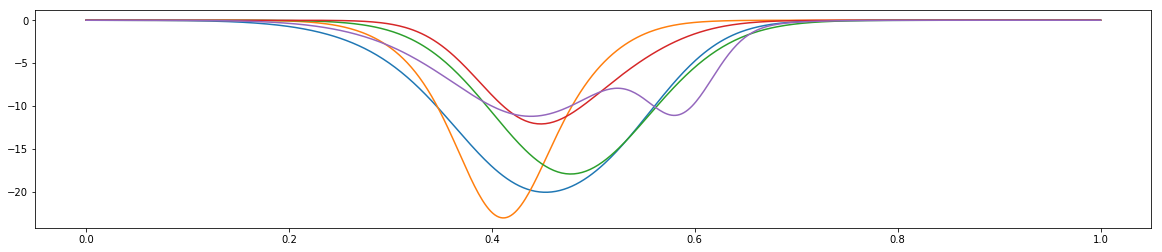

In [9]:
np_potentials, np_x = generate_potentials(dataset_size=M, points=G, n_gauss=n_gauss, length=length,
                                          a_minmax=a_minmax, b_minmax=b_minmax, c_minmax=c_minmax, 
                                          return_x=True, seed=seed)
h = (max(np_x) - min(np_x))/(G-1) # discretization width [bohr]

preview = 5

plt.figure(figsize=(20, 4))
plt.plot(np_x, np.transpose(np_potentials)[:, :preview]) # only plot first potentials
plt.show()

In [0]:
solver = NumerovSolver(G, h)

In [0]:
progress = widgets.IntProgress(value=0, max=np_potentials.shape[0], description='Searching:', bar_style='info', layout=widgets.Layout(width='92%'))
display(progress)

split_energies, steps = solver.find_split_energies(np_potentials, N, progress=progress)
print("found all split energies in", steps, "steps")
print("shape:", split_energies.shape)

IntProgress(value=0, bar_style='info', description='Searching:', layout=Layout(width='92%'), max=2000)

found all split energies in 19 steps
shape: (2000, 5)


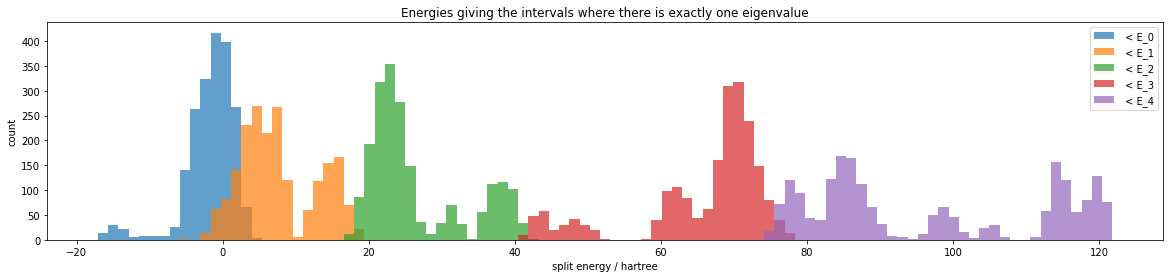

In [0]:
plt.figure(figsize=(20, 4))
bins = np.linspace(min(split_energies.flatten()), max(split_energies.flatten()), 100)

for i in range(split_energies.shape[1]):
    plt.hist(split_energies[:, i], bins, alpha=0.7, label=" < E_" + str(i))

plt.xlabel('split energy / hartree')
plt.ylabel('count')
plt.legend(loc='upper right')
plt.title("Energies giving the intervals where there is exactly one eigenvalue")
plt.show()

IntProgress(value=0, bar_style='info', description='Searching:', layout=Layout(width='92%'), max=2000)

steps to convergence:  39


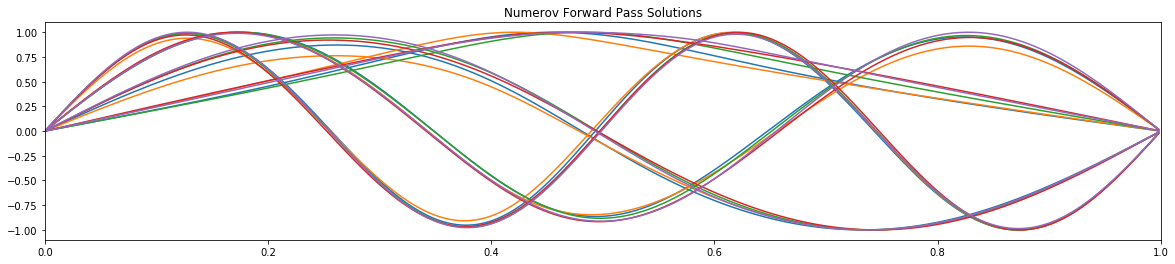

In [0]:
progress = widgets.IntProgress(value=0, max=np_potentials.shape[0], description='Searching:', bar_style='info', layout=widgets.Layout(width='92%'))
display(progress)

target_roots = np.repeat(np.expand_dims(np.arange(N), axis=0), M, axis=0)
np_solutions_forward, np_E_forward, steps = solver.solve_numerov(np_potentials, target_roots, split_energies, progress=progress)
np_solutions_forward /= np.expand_dims(np.nanmax(np.abs(np_solutions_forward), axis=1), axis=1)
print("steps to convergence: ", steps)

assert not np.any(np.all(np.isnan(np_solutions_forward), axis=1))

plt.figure(figsize=(20, 4))
for i, np_plot in enumerate(np_solutions_forward[:preview]):
    plt.plot(np_x, np_plot, 'C' + str(i%10))
plt.xlim(np_x[[0, -1]])
plt.title('Numerov Forward Pass Solutions')
plt.show()


IntProgress(value=0, bar_style='info', description='Searching:', layout=Layout(width='92%'), max=2000)

steps to convergence:  39


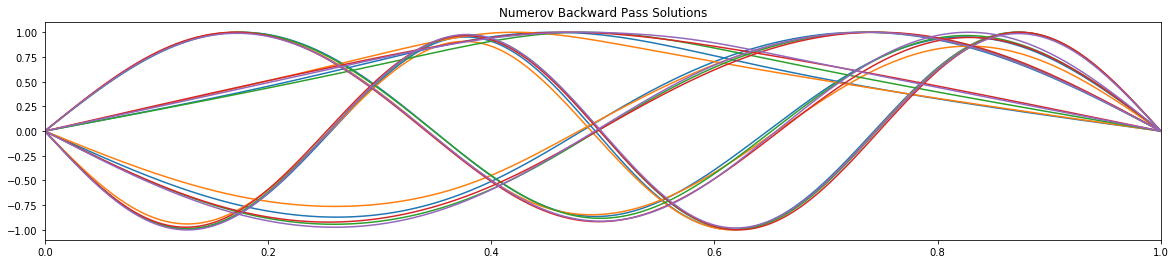

In [0]:
progress = widgets.IntProgress(value=0, max=np_potentials.shape[0], description='Searching:', bar_style='info', layout=widgets.Layout(width='92%'))
display(progress)

np_solutions_backward, np_E_backward, steps = solver.solve_numerov(np.flip(np_potentials, axis=1), target_roots, split_energies, progress=progress)
np_solutions_backward = np.flip(np_solutions_backward, axis=1)
np_solutions_backward /= np.expand_dims(np.nanmax(np.abs(np_solutions_backward), axis=1), axis=1)
print("steps to convergence: ", steps)

assert not np.any(np.all(np.isnan(np_solutions_backward), axis=1))

plt.figure(figsize=(20, 4))
for i, np_plot in enumerate(np_solutions_backward[:preview]):
    plt.plot(np_x, np_plot, 'C' + str(i%10))
    plt.xlim(np_x[[0, -1]])
plt.title('Numerov Backward Pass Solutions')
plt.show()


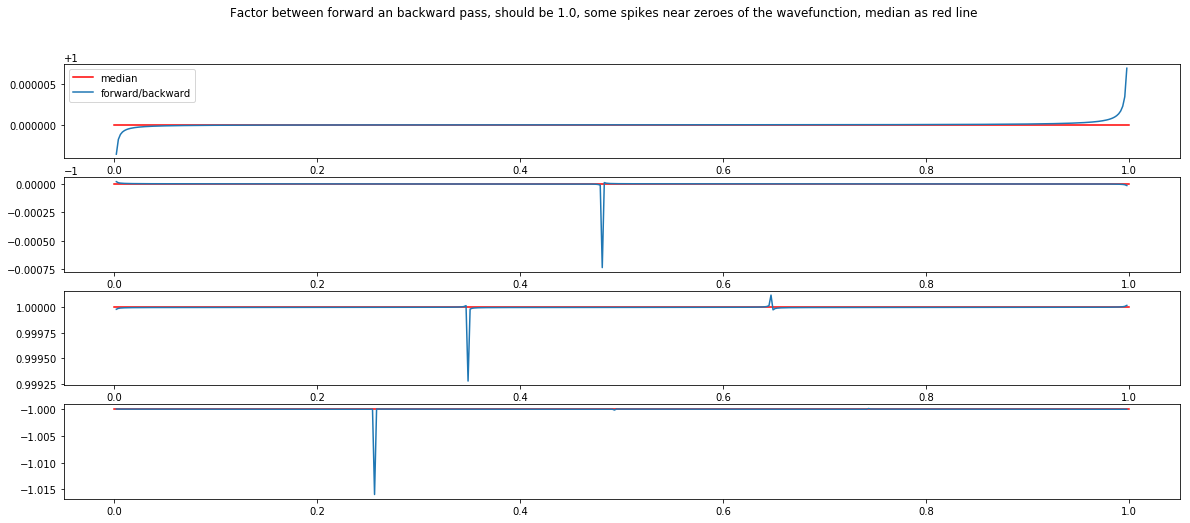

In [0]:
np_factor = np_solutions_forward/np_solutions_backward
np_median = np.nanmedian(np_factor, axis=1)

assert not np.any(np.all(np.isnan(np_factor), axis=1))


merge_preview = 1
merge_preview_n_max = 4

fig, axs = plt.subplots(N, 1, figsize=(20, 8))
for i, np_plot in enumerate(np_factor[:merge_preview]):
    for n, np_plot_single in enumerate(np_plot.transpose()):
        axs[n].plot(np_x, np.ones(np_x.shape)*np_median[i, n], 'r', label="median")
        axs[n].plot(np_x, np_plot_single, 'C' + str(i%10), label="forward/backward")
        if n == 0: axs[n].legend(loc='best')
fig.suptitle('Factor between forward an backward pass, should be 1.0, some spikes near zeroes of the wavefunction, median as red line')
plt.show()


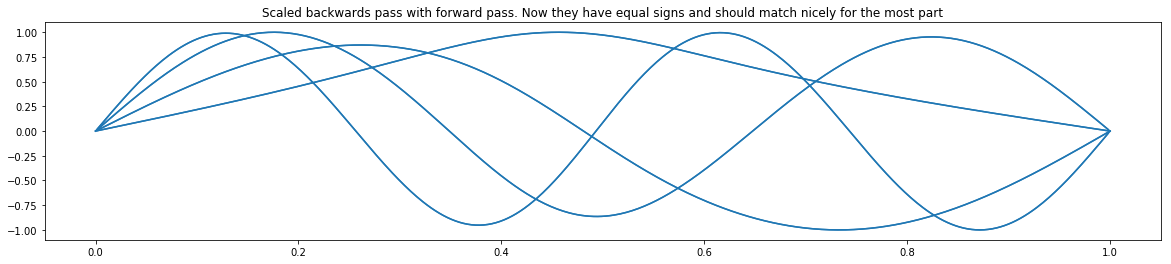

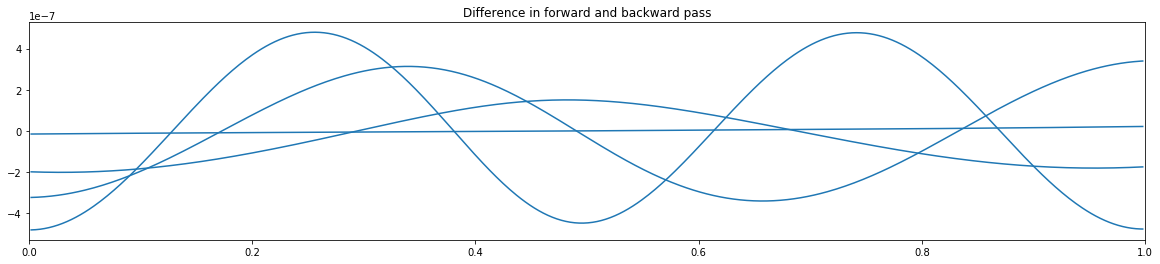

maximal absolute errors:
[[2.13728764e-08 2.01540429e-07 3.40855632e-07 4.81348330e-07]]
dataset maximal absolute error: 6.245155821753279e-07


In [0]:
np_solutions_backward_scaled = np_solutions_backward*np.expand_dims(np_median, axis=1)

plt.figure(figsize=(20, 4))
for i, np_plot in enumerate(np_solutions_backward_scaled[:merge_preview]):
    plt.plot(np_x, np_plot, 'C' + str(i%10))
for i, np_plot in enumerate(np_solutions_forward[:merge_preview]):
    plt.plot(np_x, np_plot, 'C' + str(i%10))
plt.title('Scaled backwards pass with forward pass. Now they have equal signs and should match nicely for the most part')
plt.show()

plt.figure(figsize=(20, 4))
for i, np_plot in enumerate(np_solutions_forward[:merge_preview] - np_solutions_backward_scaled[:merge_preview]):
    plt.plot(np_x, np_plot, 'C' + str(i%10))
plt.xlim(np_x[[0, -1]])
plt.title('Difference in forward and backward pass')
plt.show()

join_error = np.nanmax(np.abs(np_solutions_backward_scaled - np_solutions_forward), axis=1)
print("maximal absolute errors:")
print(join_error[:merge_preview])
print("dataset maximal absolute error:", np.max(join_error))

In [0]:
join_index = np.nanargmin(np.abs(np_solutions_backward_scaled - np_solutions_forward), axis=1)
join_mask = np.expand_dims(np.expand_dims(np.arange(np_solutions_backward_scaled.shape[1]), axis=0), axis=2) >= np.expand_dims(join_index, axis=1)

np_solutions = np_solutions_forward.copy()
np_solutions[join_mask] = np_solutions_backward_scaled[join_mask]

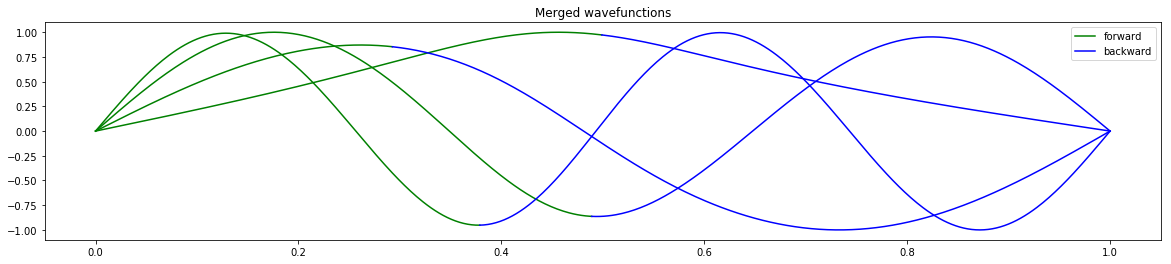

In [0]:
plt.figure(figsize=(20, 4))
for i, np_plot in enumerate(np_solutions[:merge_preview]):
    for n, np_plot_single in enumerate(np_plot.transpose()):
        plt.plot(np_x[:join_index[i, n]], np_solutions_forward[i, :join_index[i, n], n], 'g')
        plt.plot(np_x[join_index[i, n]-1:], np_solutions_backward_scaled[i, join_index[i, n]-1:, n], 'b')
plt.legend(['forward', 'backward'])
plt.title('Merged wavefunctions')
plt.show()

In [0]:
# normalization
np_norm = np_solutions**2
np_norm = integrate_simpson(np_norm, h, axis=1)
np_solutions *= 1/np.sqrt(np.expand_dims(np_norm, axis=1))

assert not np.any(np.all(np.isnan(np_solutions), axis=1))

print('max energy error:', np.max(np_E_forward - np_E_backward))
np_E = 0.5*(np_E_forward + np_E_backward)

max energy error: 0.0


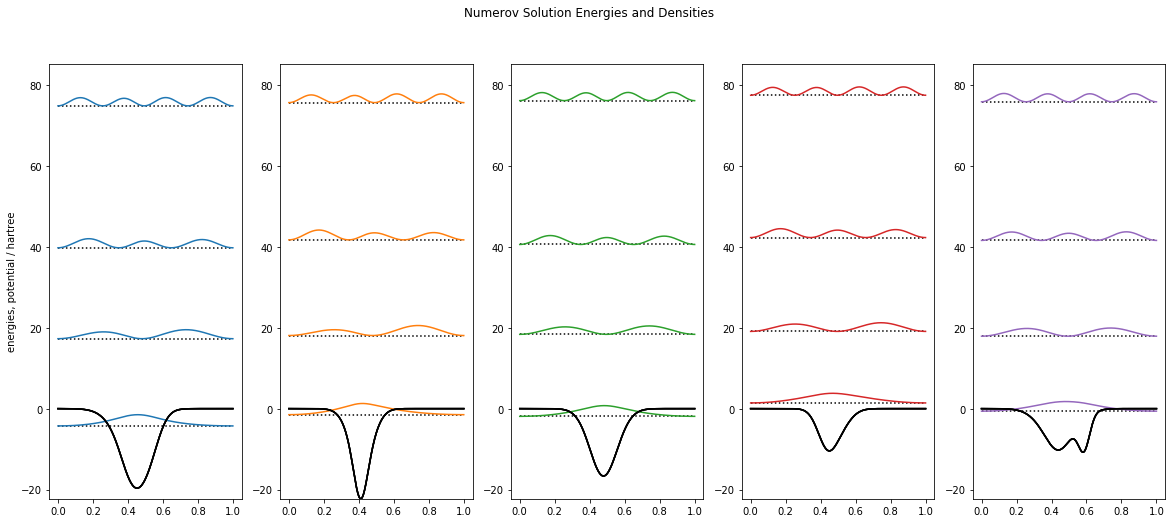


eigenvalue energies:
 [[-4.2700253 17.273804  39.72557   74.78374  ]
 [-1.4882708 18.05761   41.68448   75.58116  ]
 [-1.9040565 18.347862  40.546524  76.07353  ]
 ...
 [-4.998209  16.25953   39.71579   73.617966 ]
 [-3.709785  17.706917  39.95273   74.905334 ]
 [-3.7885084 17.419952  40.140038  74.832184 ]]


In [0]:
fig, axs = plt.subplots(1, preview, figsize=(20, 8))
for i, np_plot in enumerate(np_solutions[:preview]**2 + np_E[:preview, np.newaxis, :]):
    for n, np_plot_single in enumerate(np_plot.transpose()):
        axs[i].plot(np_x, np_potentials[i], 'k')
        axs[i].plot(np_x, np.ones(np_x.shape)*np_E[i, n], ':k')
        axs[i].plot(np_x, np_plot_single, 'C' + str(i%10))
        axs[i].set_ylim([np.min(np_potentials[:preview]), max(np.max(np_E[:preview]*1.1), 0.5)])
        if i == 0: axs[i].set_ylabel('energies, potential / hartree')
fig.suptitle('Numerov Solution Energies and Densities')
plt.show()
print('\neigenvalue energies:\n', np_E)

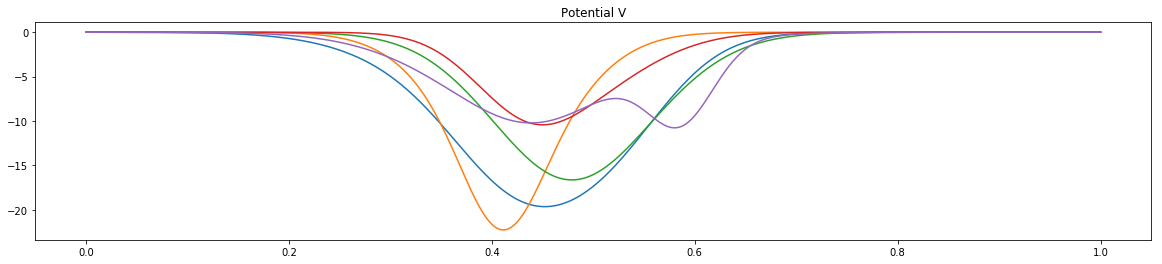

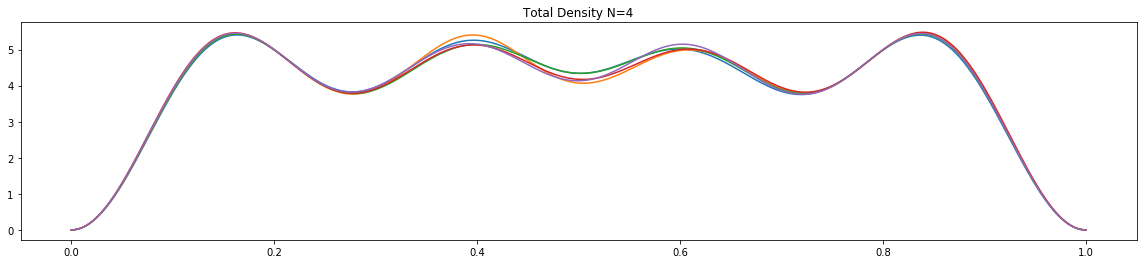

In [0]:
np_density = np.sum(np_solutions**2, axis=-1)

plt.figure(figsize=(20, 4))
plt.plot(np_x, np.transpose(np_potentials)[:, :preview])
plt.title('Potential V')
plt.show()

plt.figure(figsize=(20, 4))
for i, np_density_group in enumerate(np_density[:preview]):
    plt.plot(np_x, np_density_group, 'C' + str(i%10))
plt.title('Total Density N=' + str(N))
plt.show()

In [0]:
np_laplace = laplace(np_solutions, h)
np_kinetic = -0.5*np_solutions*np_laplace
np_K = integrate_simpson(np_kinetic, h, axis=1)
np_potential = np.expand_dims(np_potentials, axis=2)*np_solutions**2
np_P = integrate_simpson(np_potential, h, axis=1)

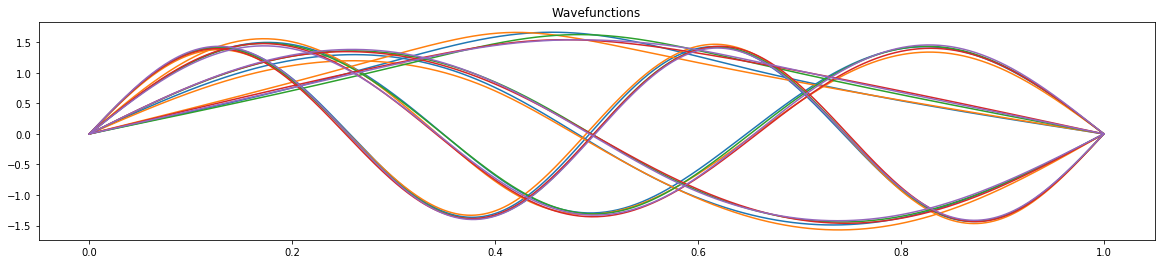

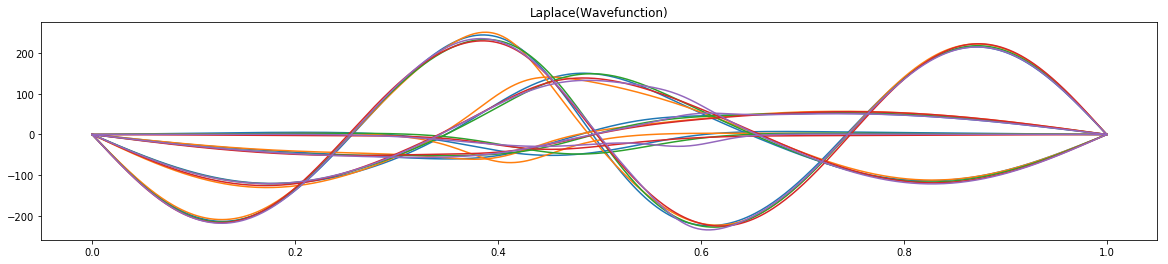

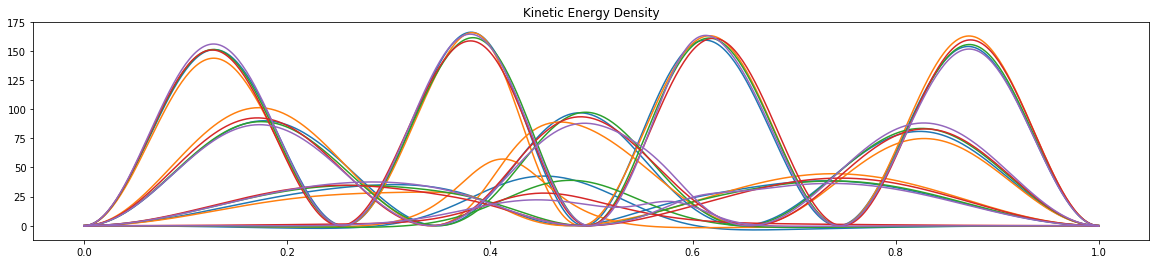

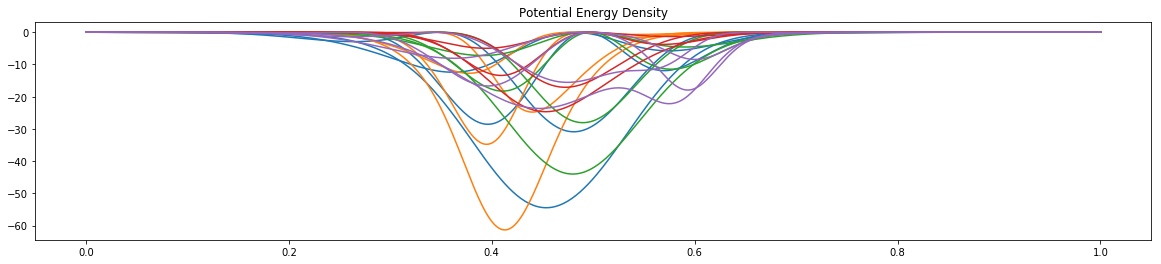

In [0]:
plt.figure(figsize=(20, 4))
for i, np_solutions_group in enumerate(np_solutions[:preview]):
    plt.plot(np_x, np_solutions_group, 'C' + str(i%10))
plt.title('Wavefunctions')
plt.show()

plt.figure(figsize=(20, 4))
for i, np_laplace_group in enumerate(np_laplace[:preview]):
    plt.plot(np_x, np_laplace_group, 'C' + str(i%10))
plt.title('Laplace(Wavefunction)')
plt.show()

plt.figure(figsize=(20, 4))
for i, np_kinetic_group in enumerate(np_kinetic[:preview]):
    plt.plot(np_x, np_kinetic_group, 'C' + str(i%10))
plt.title('Kinetic Energy Density')
plt.show()

plt.figure(figsize=(20, 4))
for i, np_potential_group in enumerate(np_potential[:preview]):
    plt.plot(np_x, np_potential_group, 'C' + str(i%10))
plt.title('Potential Energy Density')
plt.show()

In [0]:
total_energy = np.sum(np_E, axis=-1)
print('total energy:', total_energy)

potential_energy = np.sum(np_P, axis=-1)
print('potential energy:', potential_energy)

kinetic_energy = np.sum(np_K, axis=-1)
print('kinetic energy direct:', kinetic_energy)

np_K_id = np_E - np_P
kinetic_energy_id = np.sum(np_K_id, axis=-1)
print('kinetic energy indirect:', kinetic_energy_id)

assert(not np.any(np.isnan(np_density)))
assert(not np.any(np.isnan(np_kinetic)))
assert(not np.any(np.isnan(kinetic_energy)))
assert(not np.any(np.isnan(kinetic_energy_id)))

total energy: [127.513084 133.83498  133.06386  ... 124.59508  128.8552   128.60367 ]
potential energy: [-21.02838203 -14.56785498 -15.33123162 ... -23.90297399 -19.66293772
 -19.89877806]
kinetic energy direct: [148.53563451 148.39700385 148.38926718 ... 148.49220475 148.51229324
 148.49659605]
kinetic energy indirect: [148.54146835 148.40283404 148.39509347 ... 148.4980496  148.51813229
 148.50244341]
